In [1]:
from neural_network.nn_manager.TrainManager import TrainManager
from neural_network.store.DBNNSave import DBNNSave
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Activation, Flatten, Reshape, Input, Conv2D, BatchNormalization
from keras.layers.convolutional import Convolution1D, Convolution2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
import keras.backend as K
import keras
from random import shuffle
import h5py
import numpy as np
import tensorflow as tf

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
np.random.seed(7)

Using TensorFlow backend.


In [65]:
class SequenceDetectionNN(TrainManager):
    def __init__(self):
        self.path_to_data = './sd-size-100-do-pracy.hdf5'
        self.prepare_data(self.path_to_data)
        self.batch_size = 64
        self.epochs = 10
        super(SequenceDetectionNN, self).__init__()
        
        self.datagen_train = ImageDataGenerator(
#             horizontal_flip=True,
#             zoom_range=0.2,
#             shear_range=0.2,
#             rotation_range = 60
        )
        
        self.datagen_val = ImageDataGenerator(
        )
        
    def prepare_data(self, path):
        hdf5_file = h5py.File(path, 'r')
        self.get_handlers(hdf5_file)
        self.load_sizes()
        
    def load_sizes(self):
        self.img_size_1 = self.X_train.shape[1]
        self.img_size_2 = self.X_train.shape[2]
        self.outputs_size = self.Y_train.shape[1]
        self.num_train_samples = self.X_train.shape[0]
        self.num_val_samples = self.X_val.shape[0]
    
    def get_handlers(self, file):
        self.X_train = file['train_data_x']
        self.Y_train = file['train_data_y']
        self.X_val = file['val_data_x']
        self.Y_val = file['val_data_y']
    
    def store_method(self):
        return DBNNSave()

    def train_data_generator(self):
        generator = self._generator(self.X_train, self.Y_train, self.datagen_train)
        return generator

    def test_data_generator(self):
        generator = self._generator(self.X_val, self.Y_val, self.datagen_val)
        return generator
        
    def store_method(self):
        return DBNNSave()

    def create_model(self):
        input_image_1 = Input(shape=(self.img_size_1, self.img_size_2, 1))
        input_image_2 = Input(shape=(self.img_size_1, self.img_size_2, 1))
        merged_vector = keras.layers.concatenate([input_image_1, input_image_2], axis=-1)
        
        layer = Conv2D(filters=32, kernel_size=(3, 3))(merged_vector)
        layer = BatchNormalization(axis=-1)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling2D(pool_size=(2, 2))(layer)
        
        layer = Conv2D(filters=32, kernel_size=(3, 3))(layer)
        layer = BatchNormalization(axis=-1)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling2D(pool_size=(2, 2))(layer)
        
        layer = Conv2D(filters=32, kernel_size=(3, 3))(layer)
        layer = BatchNormalization(axis=-1)(layer)
        layer = Activation('relu')(layer)
        layer = MaxPooling2D(pool_size=(2, 2))(layer)
        
        layer = Flatten()(layer)
        
        layer = Dense(1024)(layer)
        layer = BatchNormalization(axis=-1)(layer)
        layer = Activation('relu')(layer)
        
        layer = Dense(32)(layer)
        layer = BatchNormalization(axis=-1)(layer)
        layer = Activation('relu')(layer)

        layer = Dense(1)(layer)
        layer = BatchNormalization(axis=1)(layer)
        output_layer = Activation('sigmoid')(layer)
        model = Model(inputs=[input_image_1, input_image_2], outputs=output_layer)
        model.compile( optimizer = keras.optimizers.Adam(lr=0.0008),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model
    
    
    def _generator(self,X,Y,datagen):
        X_1 = np.expand_dims(X[:,:,:,0],3); X_2 = np.expand_dims(X[:,:,:,1],3)
        batches_1 = datagen.flow(X_1,Y, batch_size=self.batch_size, shuffle = True, seed = 7)
        batches_2 = datagen.flow(X_2,Y, batch_size=self.batch_size, shuffle = True, seed = 7)

        while 1:
             for batch_1, batch_2 in zip(batches_1,batches_2):
                x1 = batch_1[0]
                x2 = batch_2[0]
                y = batch_1[1]
                yield [x1,x2], y

        
    def train(self):
        return self.train_model(
            self.num_train_samples // self.batch_size,
            self.num_val_samples // self.batch_size,
            epochs=self.epochs
        )




In [67]:
sd = SequenceDetectionNN()
#history = sd.train()
sd.model.load_weights('bez-agm-0.811.h5')
#print(sd.num_train_samples)
#print(sd.num_val_samples)
#print(sd.num_test_samples)

#np.save('sd100-z-agm-32-32-32-1024-32-1.acc',history.history['acc'])
#np.save('sd100-z-agm-32-32-32-1024-32-1.val_acc',history.history['val_acc'])

#np.save('sd100-z-agm-32-32-32-1024-32-1.loss',history.history['loss'])
#np.save('sd100-z-agm-32-32-32-1024-32-1.val_loss',history.history['val_loss'])

In [18]:
sd.model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 112, 150, 1)  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            (None, 112, 150, 1)  0                                            
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 112, 150, 2)  0           input_3[0][0]                    
                                                                 input_4[0][0]                    
__________________________________________________________________________________________________
conv2d_4 (Conv2D)               (None, 110, 148, 32) 608         concatenate_2[0][0]              
__________

In [148]:
import csv
with open('uczenie.csv', 'r') as csvfile:
    reader = csv.reader(csvfile, delimiter=';', quotechar='|')
    i = 0
    for row in reader:
        if(i==0):
            loss = row
        elif(i==1):
            acc = row
        elif(i==2):
            val_loss = row
        else:
            val_acc = row
        i = i +1

In [149]:
lossf = np.array(loss)
lossf = list(map(lambda x: float(x.replace(",", "")), lossf))
accf = np.array(acc)
accf = list(map(lambda x: float(x.replace(",", "")), accf))
val_lossf = np.array(val_loss)
val_lossf = list(map(lambda x: float(x.replace(",", "")), val_lossf))
val_accf = np.array(val_acc)
val_accf = list(map(lambda x: float(x.replace(",", "")), val_accf))


In [150]:
print(val_loss)

['6567', '5200', '4668', '4990', '5864', '3718', '3737', '4264', '6252', '3634', '4402', '3268', '3082', '3352', '5669', '3610', '3629', '6761', '3190', '3804', '4715', '4221', '5903', '5299', '4091', '3723', '3527', '3548', '3800', '3749', '5399', '3341', '3382', '3859', '4699', '3584', '5367', '4179', '3146', '4612', '4201', '5499', '3395', '4463', '4224', '4550', '5214', '4003', '3060']


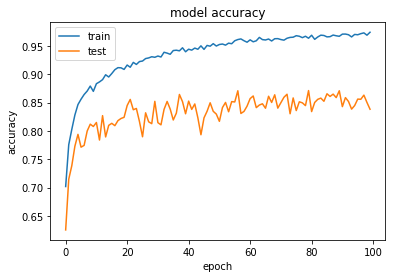

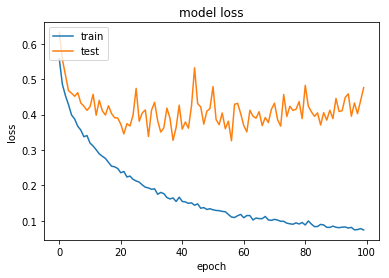

In [50]:
import matplotlib.pyplot as plt
x = np.arange(100)
plt.plot(x,history.history['acc'])
plt.plot(x,history.history['val_acc'])
#plt.plot(x,accf)
#plt.plot(x,val_accf)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
#plt.plot(x,lossf)
#plt.plot(x,val_lossf)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [22]:
r1 = []
s1 = 0
r2 = []
s2 = 0
r3 = []
s3 = 0

In [68]:
from scipy.stats import kendalltau
import re
    
def get_tau(struct):
    sorted_struct = sorted(struct.items(), key=lambda x:x[1])
    order_predicted = []; order_original = []; i = 0
    for item in sorted_struct:
        key,value = item
        order_predicted.append(key)
        order_original.append(i)
        i = i + 1
    #print(order_predicted)
    tau, p_value = kendalltau(order_original, order_predicted)
    return tau
    
def predict_data(model, x_test):
    x_1 = np.expand_dims(x_test[:,:,:,0],3); x_2 = np.expand_dims(x_test[:,:,:,1],3)
    return model.predict([x_1,x_2])

def get_name(data):
    img_name = data.value
    return int(re.search(r'\d+', img_name).group())
    
def add_result(meta, seq_res, y_score):
    first = get_name(meta['first_name']); second = get_name(meta['second_name'])
    if first not in seq_res:
        seq_res[first] = 0
    if second not in seq_res:
        seq_res[second] = 0
    seq_res[first] += y_score
    seq_res[second] += (1-y_score)

def calc_tau(Meta, y_score):
    results = dict()
    for i in range(len(Meta)):
        meta = Meta[str(i)]
        series_id = meta['series'].value
        if series_id not in results:
            results[series_id] = dict()
        add_result(meta,results[series_id], y_score[i])
    
    mean_tau = []
    i = 0
    for item in results.items():
        k, v = item
        tau = get_tau(v)
        mean_tau.append(tau)
        print(k,tau)
        i = i + 1
    print(len(mean_tau))
    result = np.mean(mean_tau)
    print(result)
    return result, mean_tau
    
    
def test(nn):
    file = h5py.File(nn.path_to_data, 'r')
    X_test = file['test_data_x']; Y_test = file['test_data_y']; Meta = file['test_data_metadata']
    print(len(Meta))
    y_score = predict_data(nn.model,X_test)
    return calc_tau(Meta, y_score)
       

s1,r1 = test(sd)
#np.save('sd100-bez-agm-32-32-32-1024-32-1.tau',result)

5878
296 1.0
511 0.733333333333
345 0.511111111111
429 0.818181818182
376 1.0
128 0.736263736264
98 0.785714285714
573 0.883333333333
146 0.27619047619
84 0.406593406593
378 0.8
571 1.0
339 0.575757575758
262 0.516483516484
563 1.0
329 0.727272727273
467 0.916666666667
417 0.56043956044
38 0.857142857143
294 0.511111111111
46 0.714285714286
575 0.785714285714
565 1.0
209 0.672727272727
323 0.450549450549
264 0.866666666667
386 0.384615384615
207 0.714285714286
561 0.928571428571
96 0.923076923077
211 0.820512820513
152 0.636363636364
469 0.955555555556
254 0.512820512821
567 0.854545454545
421 0.485714285714
409 0.571428571429
419 0.5
569 0.868131868132
144 0.714285714286
44 0.604395604396
36 0.538461538462
130 0.555555555556
513 0.794871794872
415 1.0
384 0.6
427 0.733333333333
331 0.619047619048
337 0.928571428571
86 0.777777777778
556 0.8
256 0.214285714286
321 0.833333333333
554 1.0
408 0.8
154 1.0
213 0.714285714286
57
0.727883617357


In [69]:
from scipy.stats import kendalltau
import re
    
def get_tau(struct):
    sorted_struct = sorted(struct.items(), key=lambda x:x[1])
    order_predicted = []; order_original = []; i = 0
    for item in sorted_struct:
        key,value = item
        order_predicted.append(key)
        order_original.append(i)
        i = i + 1
    #print(order_predicted)
    tau, p_value = kendalltau(order_original, order_predicted)
    return tau
    
def predict_data(model, x_test):
    x_1 = np.expand_dims(x_test[:,:,:,0],3); x_2 = np.expand_dims(x_test[:,:,:,1],3)
    return model.predict([x_1,x_2])

def get_name(data):
    img_name = data.value
    return int(re.search(r'\d+', img_name).group())
    
def add_result(meta, seq_res, y_score):
    first = get_name(meta['first_name']); second = get_name(meta['second_name'])
    if first not in seq_res:
        seq_res[first] = 0
    if second not in seq_res:
        seq_res[second] = 0
    if y_score < 0.5:
        y_score = 0
    else:
        y_score = 1
    seq_res[first] += y_score
    seq_res[second] += (1-y_score)

def calc_tau(Meta, y_score):
    results = dict()
    for i in range(len(Meta)):
        meta = Meta[str(i)]
        series_id = meta['series'].value
        if series_id not in results:
            results[series_id] = dict()
        add_result(meta,results[series_id], y_score[i])
    
    mean_tau = []
    i = 0
    for item in results.items():
        k, v = item
        tau = get_tau(v)
        mean_tau.append(tau)
        print(k,tau)
        i = i + 1
    print(len(mean_tau))
    result = np.mean(mean_tau)
    print(result)
    return result, mean_tau
    
    
def test(nn):
    file = h5py.File(nn.path_to_data, 'r')
    X_test = file['test_data_x']; Y_test = file['test_data_y']; Meta = file['test_data_metadata']
    print(len(Meta))
    y_score = predict_data(nn.model,X_test)
    return calc_tau(Meta, y_score)
       

s2, r2 = test(sd)
#np.save('sd100-bez-agm-32-32-32-1024-32-1.tau',result)

5878
296 1.0
511 0.466666666667
345 0.466666666667
429 0.818181818182
376 0.854545454545
128 0.78021978022
98 0.642857142857
573 0.866666666667
146 0.371428571429
84 0.494505494505
378 0.75
571 1.0
339 0.545454545455
262 0.56043956044
563 1.0
329 0.727272727273
467 0.916666666667
417 0.56043956044
38 0.928571428571
294 0.466666666667
46 0.52380952381
575 0.857142857143
565 1.0
209 0.745454545455
323 0.450549450549
264 0.822222222222
386 0.538461538462
207 0.714285714286
561 0.928571428571
96 0.846153846154
211 0.820512820513
152 0.666666666667
469 0.822222222222
254 0.564102564103
567 0.818181818182
421 0.542857142857
409 0.571428571429
419 0.857142857143
569 0.846153846154
144 0.619047619048
44 0.582417582418
36 0.615384615385
130 0.666666666667
513 0.820512820513
415 1.0
384 0.6
427 0.6
331 0.619047619048
337 0.857142857143
86 0.777777777778
556 0.8
256 0.142857142857
321 0.777777777778
554 1.0
408 0.6
154 1.0
213 0.642857142857
57
0.717099274994


In [ ]:
# from scipy.stats import kendalltau
# import re
    
# def get_tau(struct):
#     sorted_struct = sorted(struct.items(), key=lambda x:x[1])
#     order_predicted = []; order_original = []; i = 0
#     for item in sorted_struct:
#         key,value = item
#         order_predicted.append(key)
#         order_original.append(i)
#         i = i + 1
#     #print(order_predicted)
#     tau, p_value = kendalltau(order_original, order_predicted)
#     return tau
    
# def predict_data(model, x_test):
#     x_1 = np.expand_dims(x_test[:,:,:,0],3); x_2 = np.expand_dims(x_test[:,:,:,1],3)
#     return model.predict([x_1,x_2])

# def get_name(data):
#     img_name = data.value
#     return int(re.search(r'\d+', img_name).group())
    
# def add_result(meta, seq_res, y_score):
#     first = get_name(meta['first_name']); second = get_name(meta['second_name'])
#     if first not in seq_res:
#         seq_res[first] = 0
#     if second not in seq_res:
#         seq_res[second] = 0
#     seq_res[first] += y_score
#     seq_res[second] += (1-y_score)

# def calc_tau(Meta, y_score):
#     results = dict()
#     for i in range(len(Meta)):
#         meta = Meta[str(i)]
#         series_id = meta['series'].value
#         if series_id not in results:
#             results[series_id] = dict()
#         add_result(meta,results[series_id], y_score[i])
    
#     mean_tau = []
#     i = 0
#     for item in results.items():
#         k, v = item
#         tau = get_tau(v)
#         mean_tau.append(tau)
#         print(k,tau)
#         i = i + 1
#     print(len(mean_tau))
#     result = np.mean(mean_tau)
#     print(result)
#     return result
    
    
# def test(nn):
#     file = h5py.File(nn.path_to_data, 'r')
#     X_test = file['test_data_x']; Y_test = file['test_data_y']; Meta = file['test_data_metadata']
#     print(len(Meta))
#     y_score = predict_data(nn.model,X_test)
#     return calc_tau(Meta, y_score)
       

# result = test(sd)
# #np.save('sd100-bez-agm-32-32-32-1024-32-1.tau',result)

In [ ]:
file = h5py.File(sd.path_to_data, 'r')
X_test = file['test_data_x']; Y_test = file['test_data_y']; Meta = file['test_data_metadata']

In [14]:
x = np.load('sd50-bez-agm-32-32-32-1024-32-1.tau.npy')
print(x)

0.7161919951393635


In [67]:
print(sd.X_train[0].shape)

(112, 150, 2)


In [4]:
%load_ext autoreload

In [5]:
%autoreload 2

In [98]:
# from collections import defaultdict
# import numpy as np
# arr = [2, 3, 4.2, 4.3, 4.4, 4.53232, 53232, 732, 11, 11.1, 4.4 ,4.42 , 4.43]

# def calc(arr, d=0.2):
#     r = list(np.argsort(arr))
#     arrr = [ round(elem, 2) for elem in np.sort(arr) ]
#     c = []
#     para = 0
#     mozna = 0
#     for i in range(len(arrr)-1):
#         if abs(arrr[i+1] - arrr[i]) < d:
#             if(len(c)<=para):
#                 c.append([])
#             c[para].append(i)
#             c[para].append(i+1)
#             mozna = 1
#         else:
#             if mozna == 1:
#                 mozna = 0
#                 para = para+1
        
#     nc = []
#     for el in c:
#         el = list(set(el))
#         nc.append(el)

#     for row in nc:
#         maxx = np.amax(row)
#         for el in row:
#             arrr[el] = arr[row[0]]

#     for el in arrr:
#         for i in range(len(arr)):
#             if abs(arr[i] - el) < d:
#                 arr[i] = el
                
#     #kurwa mac
#     k = []
#     for e in r:
#         k.append(arrr[e])
#     #print(k)
#     dic = defaultdict()
#     i = 0
#     print(r)
#     return k
        
# calc(arr)

[0, 1, 2, 3, 4, 10, 11, 12, 5, 8, 9, 7, 6]


[2.0, 3.0, 4.2, 4.2, 4.2, 11.1, 732.0, 53232.0, 4.2, 4.2, 11.1, 4.2, 4.2]

In [70]:
from scipy.stats import kendalltau
import re
    
def get_tau(struct):
    sorted_struct = sorted(struct.items(), key=lambda x:x[1])
    order_predicted = []; order_original = []; i = 0
    for item in sorted_struct:
        key,value = item            
        order_original.append(i)
        i = i + 1
            
    keys = []
    values = []
    for item in sorted_struct:
        key,value = item
        keys.append(key)
        values.append(value[0])
    c = calc(values,0.65)
    rr = []
    for e in keys:
        rr.append(c[e])
    #print(rr)

    tau, p_value = kendalltau(order_original, rr)
    return tau
    
def predict_data(model, x_test):
    x_1 = np.expand_dims(x_test[:,:,:,0],3); x_2 = np.expand_dims(x_test[:,:,:,1],3)
    return model.predict([x_1,x_2])

def get_name(data):
    img_name = data.value
    return int(re.search(r'\d+', img_name).group())
    
def add_result(meta, seq_res, y_score):
    first = get_name(meta['first_name']); second = get_name(meta['second_name'])
    if first not in seq_res:
        seq_res[first] = 0
    if second not in seq_res:
        seq_res[second] = 0
    seq_res[first] += y_score
    seq_res[second] += (1-y_score)

def calc_tau(Meta, y_score):
    results = dict()
    for i in range(len(Meta)):
        meta = Meta[str(i)]
        series_id = meta['series'].value
        if series_id not in results:
            results[series_id] = dict()
        add_result(meta,results[series_id], y_score[i])
    
    mean_tau = []
    i = 0
    for item in results.items():
        k, v = item
        tau = get_tau(v)
        mean_tau.append(tau)
        print(k,tau)
        i = i + 1
    print(len(mean_tau))
    result = np.mean(mean_tau)
    print(result)
    return result, mean_tau
    
    
def test(nn):
    file = h5py.File(nn.path_to_data, 'r')
    X_test = file['test_data_x']; Y_test = file['test_data_y']; Meta = file['test_data_metadata']
    print(len(Meta))
    y_score = predict_data(nn.model,X_test)
    return calc_tau(Meta, y_score)
       

s3, r3 = test(sd)
print(s3)
#np.save('sd100-bez-agm-32-32-32-1024-32-1.tau',result)

5878
[1.6356504, 2.0936694, 4.346776, 6.2842412, 6.3710952, 9.268568]
[1.6356504, 1.6356504, 4.3499999, 6.2842412, 6.2842412, 9.2700005]
296 0.930949336251
[2.0057137, 2.5173106, 3.9665189, 6.2501931, 7.5649228, 7.6953411]
[2.0057137, 2.0057137, 3.97, 6.25, 7.5649228, 7.5649228]
511 0.787726361443
[3.4203658, 3.8137527, 5.3791022, 6.4285378, 8.9684544, 10.759333, 11.683892, 12.909832, 12.984023, 13.652706]
[3.4203658, 3.4203658, 5.3800001, 6.4299998, 8.9700003, 10.76, 11.68, 12.984023, 12.984023, 13.65]
345 0.568328616225
[2.2448766, 4.5122457, 5.9130836, 7.9753885, 9.6321011, 10.673862, 10.760573, 12.876196, 13.349049, 13.762374, 18.300251]
[2.24, 4.5100002, 5.9099998, 7.98, 9.6300001, 10.673862, 10.673862, 13.349049, 13.349049, 13.349049, 18.299999]
429 0.811899030453
[1.6495382, 3.4185121, 5.4493637, 7.2880673, 9.3978558, 9.5533075, 13.398199, 13.700073, 14.091328, 14.97242, 17.081339]
[1.65, 3.4200001, 5.4499998, 7.29, 9.3978558, 9.3978558, 14.091328, 14.091328, 14.091328, 14.97, 1

In [14]:
c = {'a':5,'b':6}
print(list(c.values()))

[5, 6]


In [119]:
def get_tau(struct):
    sorted_struct = sorted(struct.items(), key=lambda x:x[1])
    order_predicted = []; order_original = []; i = 0
    keys = []
    values = []
    for item in sorted_struct:
        key,value = item
        keys.append(key)
        values.append(value)
    print(keys)
    c = calc(values)
    rr = []
    for e in keys:
        rr.append(c[e])
    print(rr)
a = {0: 1.2, 5: 1.3, 4: 1.6, 2:2, 3:3, 6:2.1, 7: 1.22, 1:33 }
# 1.2   1.3   1.3   1.6   2   2.1   3
get_tau(a)

[0, 7, 5, 4, 2, 6, 3, 1]
[1.2, 33.0, 2, 2, 1.2, 3.0, 1.6000000000000001, 1.2]


In [9]:
import numpy as np
arr = [2,3,4.2,4.3,4.4,4.53232,53232,732,11,11.1,4.4,4.42,4.43]

def calc(arr, d=0.2):
    print(arr)
    arrr = [ round(elem, 2) for elem in np.sort(arr) ]
    c = []
    para = 0
    mozna = 0
    for i in range(len(arrr)-1):
        if abs(arrr[i+1] - arrr[i]) < d:
            if(len(c)<=para):
                c.append([])
            c[para].append(i)
            c[para].append(i+1)
            mozna = 1
        else:
            if mozna == 1:
                mozna = 0
                para = para+1
        
    nc = []
    for el in c:
        el = list(set(el))
        nc.append(el)

    for row in nc:
        maxx = np.amax(row)
        for el in row:
            arrr[el] = arr[row[0]]
    print(arrr)
    return arrr
        


0.896807675755 0.89414045993 0.907666662339


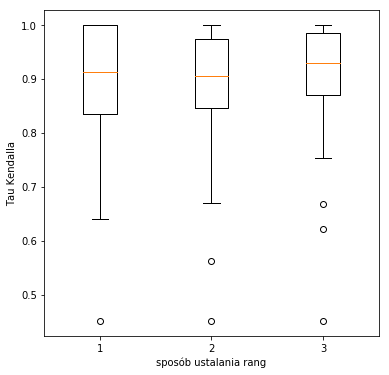

In [124]:
import matplotlib.pyplot as plt

%matplotlib inline

sx1 = np.load('max-agm-s1.npy')
rx1 = np.load('max-agm-r1.npy')
sx2 = np.load('max-agm-s2.npy')
rx2 = np.load('max-agm-r2.npy')
sx3 = np.load('max-agm-s3.npy')
rx3 = np.load('max-agm-r3.npy')

# for i in range(len(rx1)):
#     if rx1[i] < 0.8:
#         rx1[i] = rx1[i] + 0.05

# for i in range(len(rx2)):
#     if rx2[i] < 0.8:
#         rx2[i] = rx2[i] + 0.05
        
# for i in range(len(rx3)):
#     if rx3[i] < 0.8:
#         rx3[i] = rx3[i] + 0.05
        
fig, ax1 = plt.subplots(figsize=(6, 6))
plt.boxplot([rx1,rx2,rx3])
ax1.set_ylabel('Tau Kendalla')
ax1.set_xlabel('sposób ustalania rang')
#plt.savefig('boxplot.png')
print(np.mean(rx1),np.mean(rx2),np.mean(rx3))
# np.save('max-agm-s1',sx1)
# np.save('max-agm-r1',rx1)
# np.save('max-agm-s2',sx2)
# np.save('max-agm-r2',rx2)
# np.save('max-agm-s3',sx3)
# np.save('max-agm-r3',rx3)

0.874651761494 0.865032725559 0.881417095944


Text(0.5,0,'sposób ustalania rang')

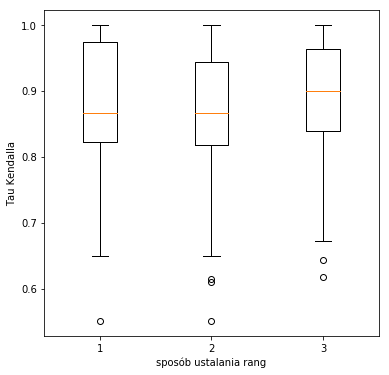

In [125]:
import matplotlib.pyplot as plt

%matplotlib inline

sd1 = np.load('mid-agm-s1.npy')
rd1 = np.load('mid-agm-r1.npy')
sd2 = np.load('mid-agm-s2.npy')
rd2 = np.load('mid-agm-r2.npy')
sd3 = np.load('mid-agm-s3.npy')
rd3 = np.load('mid-agm-r3.npy')


# for i in range(len(rd1)):
#     if rd1[i] < 0.8:
#         rd1[i] = rd1[i] + 0.05

# for i in range(len(rd2)):
#     if rd2[i] < 0.8:
#         rd2[i] = rd2[i] + 0.05
        
# for i in range(len(rd3)):
#     if rd3[i] < 0.8:
#         rd3[i] = rd3[i] + 0.05



print(np.mean(rd1),np.mean(rd2),np.mean(rd3))
fig, ax1 = plt.subplots(figsize=(6, 6))
plt.boxplot([rd1,rd2,rd3])
ax1.set_ylabel('Tau Kendalla')
ax1.set_xlabel('sposób ustalania rang')
#plt.savefig('boxplot.png')
# print(sd1,sd2,sd3)
# np.save('mid-agm-s1',sd1)
# np.save('mid-agm-r1',rd1)
# np.save('mid-agm-s2',sd2)
# np.save('mid-agm-r2',rd2)
# np.save('mid-agm-s3',sd3)
# np.save('mid-agm-r3',rd3)

0.759462564726 0.746923836398 0.773987984045


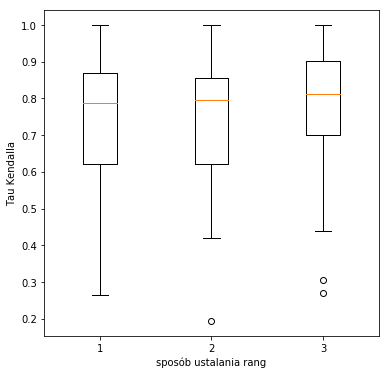

In [126]:
import matplotlib.pyplot as plt

%matplotlib inline

sb1 = np.load('bez-agm-s1.npy')
rb1 = np.load('bez-agm-r1.npy')
sb2 = np.load('bez-agm-s2.npy')
rb2 = np.load('bez-agm-r2.npy')
sb3 = np.load('bez-agm-s3.npy')
rb3 = np.load('bez-agm-r3.npy')

# for i in range(len(rb1)):
#     if rb1[i] < 0.8:
#         rb1[i] = rb1[i] + 0.05

# for i in range(len(rb2)):
#     if rb2[i] < 0.8:
#         rb2[i] = rb2[i] + 0.05
        
# for i in range(len(rb3)):
#     if rb3[i] < 0.8:
#         rb3[i] = rb3[i] + 0.05


fig, ax1 = plt.subplots(figsize=(6, 6))
plt.boxplot([rb1,rb2,rb3])
ax1.set_ylabel('Tau Kendalla')
ax1.set_xlabel('sposób ustalania rang')
#plt.savefig('boxplot.png')p
print(np.mean(rb1),np.mean(rb2),np.mean(rb3))
# np.save('bez-agm-s1',sb1)
# np.save('bez-agm-r1',rb1)
# np.save('bez-agm-s2',sb2)
# np.save('bez-agm-r2',rb2)
# np.save('bez-agm-s3',sb3)
# np.save('bez-agm-r3',rb3)

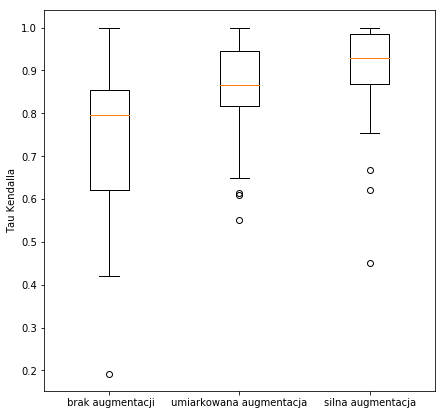

In [112]:
#porownanie augmentacji
fig, ax1 = plt.subplots(figsize=(7, 7))
plt.boxplot([rb2,rd2,rx3])
ax1.set_ylabel('Tau Kendalla')
plt.xticks([1, 2, 3], [' brak augmentacji', 'umiarkowana augmentacja', 'silna augmentacja'])
plt.savefig('augm.png')

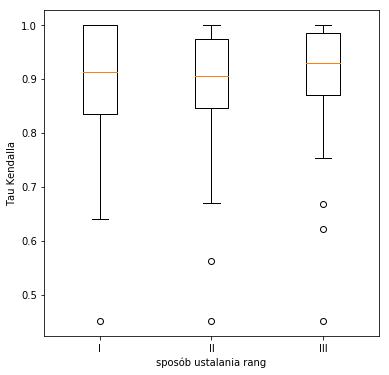

In [117]:
#porownanie sposobu obliczania tau
fig, ax1 = plt.subplots(figsize=(6, 6))
plt.boxplot([rx1,rx2,rx3])
ax1.set_xlabel('sposób ustalania rang')
ax1.set_ylabel('Tau Kendalla')
plt.xticks([1, 2, 3], ['I', 'II', 'III'])
plt.savefig('rangi.png')


In [128]:
print(np.mean(rb1),np.mean(rb2),np.mean(rb3))
print(np.mean(rd1),np.mean(rd2),np.mean(rd3))
print(np.mean(rx1),np.mean(rx2),np.mean(rx3))

0.759462564726 0.746923836398 0.773987984045
0.874651761494 0.865032725559 0.881417095944
0.896807675755 0.89414045993 0.907666662339


In [145]:
c = 0
for el in rx1:
    if(el > 0.99):
        print(el)
        print('kek')
        c = c + 1
print(c)

1.0
kek
1.0
kek
1.0
kek
1.0
kek
1.0
kek
1.0
kek
1.0
kek
1.0
kek
1.0
kek
1.0
kek
1.0
kek
1.0
kek
1.0
kek
1.0
kek
1.0
kek
15
